<a href="https://colab.research.google.com/github/duttagoutam/LJMUMasters/blob/master/Automatic_Image_Captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [3]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
import pickle
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn import metrics
from nltk.translate.bleu_score import corpus_bleu

Using TensorFlow backend.


In [0]:
folderName='/content/drive/My Drive/App/storage/Flickr8k_Dataset'
imageDir=folderName+'/Images'

In [5]:
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

filename = folderName+"/Flickr_TextData/Flickr8k.token.txt"
# load descriptions
doc = load_doc(filename)
print(doc[:300])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the s


In [6]:
def load_descriptions(doc):
	mapping = dict()
	# process lines
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		if len(line) < 2:
			continue
		# take the first token as the image id, the rest as the description
		image_id, image_desc = tokens[0], tokens[1:]
		# extract filename from image id
		image_id = image_id.split('.')[0]
		# convert description tokens back to string
		image_desc = ' '.join(image_desc)
		# create the list if needed
		if image_id not in mapping:
			mapping[image_id] = list()
		# store description
		mapping[image_id].append(image_desc)
	return mapping

# parse descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

Loaded: 8091 


In [7]:
list(descriptions.keys())[:5]

['1000268201_693b08cb0e',
 '1001773457_577c3a7d70',
 '1002674143_1b742ab4b8',
 '1003163366_44323f5815',
 '1007129816_e794419615']

In [8]:
descriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [9]:
descriptions['1001773457_577c3a7d70']

['A black dog and a spotted dog are fighting',
 'A black dog and a tri-colored dog playing with each other on the road .',
 'A black dog and a white dog with brown spots are staring at each other in the street .',
 'Two dogs of different breeds looking at each other on the road .',
 'Two dogs on pavement moving toward each other .']

In [0]:
def clean_descriptions(descriptions):
	# prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for key, desc_list in descriptions.items():
		for i in range(len(desc_list)):
			desc = desc_list[i]
			# tokenize
			desc = desc.split()
			# convert to lower case
			desc = [word.lower() for word in desc]
			# remove punctuation from each token
			desc = [w.translate(table) for w in desc]
			# remove hanging 's' and 'a'
			desc = [word for word in desc if len(word)>1]
			# remove tokens with numbers in them
			desc = [word for word in desc if word.isalpha()]
			# store as string
			desc_list[i] =  ' '.join(desc)

# clean descriptions
clean_descriptions(descriptions)

In [11]:
descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [12]:
descriptions['1001773457_577c3a7d70']

['black dog and spotted dog are fighting',
 'black dog and tricolored dog playing with each other on the road',
 'black dog and white dog with brown spots are staring at each other in the street',
 'two dogs of different breeds looking at each other on the road',
 'two dogs on pavement moving toward each other']

In [13]:
# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
	# build a list of all description strings
	all_desc = set()
	for key in descriptions.keys():
		[all_desc.update(d.split()) for d in descriptions[key]]
	return all_desc

# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 8763


In [0]:
# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(key + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()

save_descriptions(descriptions, folderName+'/descriptions.txt')

In [50]:
# load a pre-defined list of photo identifiers
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

# load training dataset (6K)
filename = folderName+"/Flickr_TextData/Flickr_8k.trainImages.txt"
train = load_set(filename)
print('Train Dataset: %d' % len(train))

# load test dataset (1K)
testfile = folderName+"/Flickr_TextData/Flickr_8k.testImages.txt"
test = load_set(testfile)
print('Test Dataset: %d' % len(test))

Train Dataset: 6000
Test Dataset: 1000


In [16]:
# Below path contains all the images
#images = '../../storage/image_caption/dataset/Flicker8k_Dataset/'
images = folderName+'/Images/'
print('images: %s' % images)
# Create a list of all image names in the directory
img = glob.glob(images + '*.jpg')
print('img: %d' % len(img))

images: /content/drive/My Drive/App/storage/Flickr8k_Dataset/Images/
img: 8099


In [17]:
# Below file conatains the names of images to be used in train data
train_images_file = folderName+"/Flickr_TextData/Flickr_8k.trainImages.txt"
# Read the train image names in a set
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))
print('train_images: %d' % len(train_images))
# Create a list of all the training images with their full path names
train_img = []
print(len(images))
for i in img: # img is list of full path names of all images
    if i[len(images):] in train_images: # Check if the image belongs to training set
        train_img.append(i) # Add it to the list of train images

print('train_img: %d' % len(train_img))

train_images: 6000
60
train_img: 6000


In [18]:
# Below file conatains the names of images to be used in test data
test_images_file = folderName+"/Flickr_TextData/Flickr_8k.testImages.txt"
# Read the validation image names in a set# Read the test image names in a set
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))
print('test_images: %d' % len(test_images))
# Create a list of all the test images with their full path names
test_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in test_images: # Check if the image belongs to test set
        test_img.append(i) # Add it to the list of test images

print('test_img: %d' % len(test_img))

test_images: 1000
test_img: 1000


In [51]:
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions

# descriptions
train_descriptions = load_clean_descriptions(folderName+'/descriptions.txt', train)
print('Train Descriptions: train=%d' % len(train_descriptions))

# descriptions
test_descriptions = load_clean_descriptions(folderName+'/descriptions.txt', test)
print('Test Descriptions: train=%d' % len(test_descriptions))

Train Descriptions: train=6000
Test Descriptions: train=1000


In [0]:
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x

In [21]:
# Load the inception v3 model
model = InceptionV3(weights='imagenet')














96116736/96112376 [==============================] - 1s 0us/step


In [0]:
# Create a new model, by removing the last layer (output layer) from the inception v3
model_new = Model(model.input, model.layers[-2].output)

In [0]:
# Function to encode a given image into a vector of size (2048, )
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

In [160]:
# Call the funtion to encode all the train images
# This will take a while on CPU - Execute this only once

start = time()
encoding_train = {}
for img in train_img:
    encoding_train[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

KeyboardInterrupt: ignored

In [0]:
import pickle
# Save the bottleneck train features to disk
with open(folderName+"/encoded_train_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)

In [41]:
# Call the funtion to encode all the test images - Execute this only once
start = time()
encoding_test = {}
for img in test_img:
    encoding_test[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 663.5420525074005


In [0]:
# Save the bottleneck test features to disk
with open(folderName+"/encoded_test_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)

In [24]:
train_features = load(open(folderName+"/encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=6000


In [25]:
test_features = load(open(folderName+"/encoded_test_images.pkl", "rb"))
print('Photos: test=%d' % len(test_features))

Photos: test=1000


In [26]:
# Create a list of all the training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

30000

In [27]:
# Consider only words which occur at least 10 times in the corpus
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 7578 -> 1651


In [0]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [29]:
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

1652

In [30]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 34


In [0]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

In [32]:
# Load Glove vectors
# glove_dir = '../../storage/glove'
glove_dir = folderName+"/Flickr_TextData/"
embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [0]:
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [34]:
embedding_matrix.shape

(1652, 200)

In [35]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [36]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 200)      330400      input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [37]:
model.layers[2]

In [0]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [39]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
epochs = 10
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath

In [0]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('./model_weights/model_' + str(i) + '.h5')

Epoch 1/1
2000/2000 [==============================] - 134s 67ms/step - loss: 4.1161
Epoch 1/1
2000/2000 [==============================] - 131s 65ms/step - loss: 3.4084
Epoch 1/1
2000/2000 [==============================] - 121s 60ms/step - loss: 3.1949
Epoch 1/1
2000/2000 [==============================] - 122s 61ms/step - loss: 3.0587
Epoch 1/1
2000/2000 [==============================] - 118s 59ms/step - loss: 2.9650
Epoch 1/1
2000/2000 [==============================] - 119s 59ms/step - loss: 2.8900
Epoch 1/1
2000/2000 [==============================] - 118s 59ms/step - loss: 2.8345
Epoch 1/1
2000/2000 [==============================] - 118s 59ms/step - loss: 2.7878
Epoch 1/1
2000/2000 [==============================] - 118s 59ms/step - loss: 2.7484
Epoch 1/1
2000/2000 [==============================] - 118s 59ms/step - loss: 2.7090


In [0]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('./model_weights/model_' + str(i) + '.h5')

Epoch 1/1
2000/2000 [==============================] - 118s 59ms/step - loss: 2.6823
Epoch 1/1
2000/2000 [==============================] - 118s 59ms/step - loss: 2.6567
Epoch 1/1
2000/2000 [==============================] - 118s 59ms/step - loss: 2.6342
Epoch 1/1
2000/2000 [==============================] - 118s 59ms/step - loss: 2.6129
Epoch 1/1
2000/2000 [==============================] - 118s 59ms/step - loss: 2.5916
Epoch 1/1
2000/2000 [==============================] - 118s 59ms/step - loss: 2.5761
Epoch 1/1
2000/2000 [==============================] - 118s 59ms/step - loss: 2.5610
Epoch 1/1
2000/2000 [==============================] - 118s 59ms/step - loss: 2.5488
Epoch 1/1
2000/2000 [==============================] - 118s 59ms/step - loss: 2.5363
Epoch 1/1
2000/2000 [==============================] - 118s 59ms/step - loss: 2.5255


In [0]:
model.optimizer.lr = 0.0001
epochs = 10
number_pics_per_bath = 6
steps = len(train_descriptions)//number_pics_per_bath

In [60]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    #model.save('./model_weights/model_' + str(i) + '.h5')



Epoch 1/1
1000/1000 [==============================] - 754s 754ms/step - loss: 5.1461
Epoch 1/1
1000/1000 [==============================] - 749s 749ms/step - loss: 4.4219
Epoch 1/1
1000/1000 [==============================] - 750s 750ms/step - loss: 4.0700
Epoch 1/1
1000/1000 [==============================] - 747s 747ms/step - loss: 3.8722
Epoch 1/1
1000/1000 [==============================] - 751s 751ms/step - loss: 3.7384
Epoch 1/1
1000/1000 [==============================] - 753s 753ms/step - loss: 3.6374
Epoch 1/1
1000/1000 [==============================] - 750s 750ms/step - loss: 3.5530
Epoch 1/1
1000/1000 [==============================] - 752s 752ms/step - loss: 3.4840
Epoch 1/1
1000/1000 [==============================] - 754s 754ms/step - loss: 3.4240
Epoch 1/1
1000/1000 [==============================] - 755s 755ms/step - loss: 3.3723


In [0]:
#model.save_weights('./model_weights/model_30.h5')
model.save_weights(folderName+'/'+'model_30.h5')

In [0]:
model.load_weights(folderName+'/model_30.h5')

In [0]:
#images = '../../storage/image_caption/dataset/Flicker8k_Dataset/'
images =imageDir+'/'

In [0]:
with open(folderName+"/encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

In [0]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [0]:
from nltk.translate.bleu_score import corpus_bleu
# evaluate the skill of the model
def evaluate_model(testdescriptionstext, predictiontext):
	actual, predicted = list(), list()
	# step over the whole set
	#for key, desc in testdescriptionstext.items():
	for desc in testdescriptionstext:
		# generate description
		#yhat = generate_desc(model, tokenizer, photos[key], max_length)
		# store actual and predicted
		#actual.append([desc.split()])
		references = [d.split() for d in desc]
		#references = testdescriptionstext[i]
		actual.append(references)
		predicted.append(predictiontext)
		print('Actual:    %s' % desc)
		print('Predicted: %s' % predictiontext)
		# calculate BLEU score
		bleu = corpus_bleu(actual, predicted)
		print("bleu_score:",bleu)
	return bleu

387830531_e89c192b92.jpg
387830531_e89c192b92
['startseq brown dog about to jump on smaller black and tan dog endseq', 'startseq large dog playing with smaller dog endseq', 'startseq two dogs are playing together outside endseq', 'startseq two dogs playing in the grass with an adult nearby endseq', 'startseq two dogs playing with each other endseq']
[[0.12316725 0.21275459 0.20689955 ... 0.5095811  0.04995344 0.01672048]]


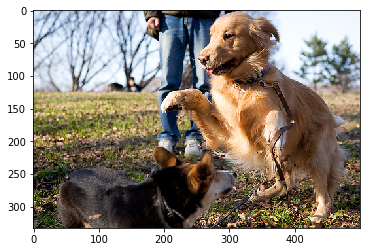

Greedy: two dogs are running through the grass
Actual:    startseq brown dog about to jump on smaller black and tan dog endseq
Predicted: two dogs are running through the grass
bleu_score: 0.733503637924837
Actual:    startseq large dog playing with smaller dog endseq
Predicted: two dogs are running through the grass
bleu_score: 0.7417004814749555
Actual:    startseq two dogs are playing together outside endseq
Predicted: two dogs are running through the grass
bleu_score: 0.749634235443537
Actual:    startseq two dogs playing in the grass with an adult nearby endseq
Predicted: two dogs are running through the grass
bleu_score: 0.7535084431893706
Actual:    startseq two dogs playing with each other endseq
Predicted: two dogs are running through the grass
bleu_score: 0.752738377346319
final bleu_score: 0.752738377346319


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [88]:
z=1
pic = list(encoding_test.keys())[z]
print(pic)
name = pic.strip('.jpg')
print(name)
print(test_descriptions[name])
image = encoding_test[pic].reshape((1,2048))
print(image)
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
predicted = greedySearch(image)
print("Greedy:",predicted)
# evaluate model
bleu_score = evaluate_model(test_descriptions[name], predicted)
print("final bleu_score:",bleu_score)

In [0]:
"Beam Search, inspired by the example provided but tailor-made for our model"

import tensorflow as tf
import numpy as np
# import data


class Hypothesis(object):
    """Class to represent a hypothesis during beam search. Holds all the information needed for the hypothesis."""

    def __init__(self, tokens, log_probs):
        self.tokens = tokens
        self.log_probs = log_probs

    def extend(self, token, log_prob):
        """Return a NEW hypothesis, extended with the information from the latest step of beam search.

        Args:
        token: Integer. Latest token produced by beam search.
        log_prob: Float. Log prob of the latest token.
        state: Current decoder state, a LSTMStateTuple.
        Returns:
        New Hypothesis for next step.
        """
        return Hypothesis(tokens = self.tokens + [token],
        log_probs = self.log_probs + [log_prob])

    @property
    def get_tokens(self):
        return self.tokens

    @property
    def latest_token(self):
        return self.tokens[-1]

    @property
    def log_prob(self):
    # the log probability of the hypothesis so far is the sum of the log probabilities of the tokens so far
        return sum(self.log_probs)

    @property
    def avg_log_prob(self):
    # normalize log probability by number of tokens (otherwise longer sequences always have lower probability)
        return self.log_prob / len(self.tokens)


def decode_one_step(cap_inputs, img_feats, decoder_model, len_hyps, beam_size, words_indices, indices_words):

    topk_probs = []
    topk_ids = []

    for i in range(len_hyps):

        cap_input = cap_inputs[i]
        img_feat = img_feats[i]
#         print(cap_input)
        
        pred_prob_t = decoder_model.predict([img_feat, cap_input] , verbose = 0)

        topk_prob = np.sort(pred_prob_t[0], axis=-1)[-(beam_size):][::-1]

        topk_logprob = -np.log(topk_prob)

        topk_id = np.argsort(pred_prob_t[0], axis=-1)[-(beam_size):][::-1]

        topk_probs.append(topk_logprob)
        topk_ids.append(topk_id)

    return topk_probs, topk_ids

def run_beam_search(encoding, decoder_model, words_indices, indices_words, \
      min_dec_steps, max_dec_steps, num_hyps, beam_size):

    #beam search decoding 
    encoder_output = encoding
    # Initialize beam_size-many hypotheses
    hyps = [Hypothesis(tokens=[words_indices.get('startseq')],
    log_probs=[0.0]                      
                     # zero vector of length attention_length
                     ) for _ in range(num_hyps)]

    results = [] # this will contain finished hypotheses (those that have emitted the [STOP] token)

    steps = 0
    while steps < max_dec_steps and len(results) < beam_size:

        hyp_tokens = [h.get_tokens for h in hyps] # latest token produced by each hypothesis

        len_hyps = len(hyp_tokens)

        img_feats = np.array([encoder_output] * len_hyps)

        dec_inputs = []
#         dec_inputs = hyp_tokens
        for dec_input in hyp_tokens:
            dec_inputs.append(pad_sequences([dec_input], maxlen=max_length))
    # dec_inputs = np.array(dec_inputs)
    # dec_inputs = np.reshape(dec_inputs, (dec_inputs.shape[0], 1))


    # Run one step of the decoder to get the new info
        topk_log_probs, topk_ids = decode_one_step(
          dec_inputs, img_feats, decoder_model, len_hyps, beam_size, words_indices, indices_words)

        topk_log_probs = np.array(topk_log_probs)
        topk_ids = np.array(topk_ids)


    # Extend each hypothesis and collect them all in all_hyps
        all_hyps = []
        num_orig_hyps = 1 if steps == 0 else len(hyps) # On the first step, we only had one original hypothesis (the initial hypothesis). 
                                                       # On subsequent steps, all original hypotheses are distinct.
        for i in range(num_orig_hyps):
            h = hyps[i]  # take the ith hypothesis and new decoder state info
            for j in range(beam_size):  # for each of the top 2*beam_size hyps:
            # Extend the ith hypothesis with the jth option

                logprobs= np.array(topk_log_probs[i,j])
                new_hyp = h.extend(token=topk_ids[i,j], log_prob=logprobs)
                all_hyps.append(new_hyp)

        # Filter and collect any hypotheses that have produced the end token.
        hyps = [] # will contain hypotheses for the next step

        for h in sort_hyps(all_hyps): # in order of most likely h
            if h.latest_token == words_indices.get('endseq'): # if stop token is reached...
        # If this hypothesis is sufficiently long, put in results. Otherwise discard.
                if steps >= min_dec_steps:
                    results.append(h)
            else: # hasn't reached stop token, so continue to extend this hypothesis
                hyps.append(h)
            if len(hyps) == beam_size or len(results) == beam_size:
        # Once we've collected beam_size-many hypotheses for the next step, or beam_size-many complete hypotheses, stop.
                break

        steps += 1

    # At this point, either we've got beam_size results, or we've reached maximum decoder steps

    if len(results)==0: # if we don't have any complete results, add all current hypotheses (incomplete summaries) to results
        results = hyps

    # Sort hypotheses by average log probability
    hyps_sorted = sort_hyps(results)
    
    # Return the hypothesis with highest average log prob
    translated_hyps = get_string_from_hypothesis(hyps_sorted)
    return translated_hyps

def sort_hyps(hyps):
    """Return a list of Hypothesis objects, sorted by average log probability"""
    return sorted(hyps, key=lambda h: h.avg_log_prob, reverse=False)

def get_string_from_hypothesis(sorted_hyps):
    stringHyps = []
    for hypothesis in sorted_hyps:
        
        stringHyp = ''
        for token in hypothesis.tokens:
            stringHyp += ' ' + ixtoword[token]
            
        stringHyps.append(stringHyp)    
        
    return stringHyps

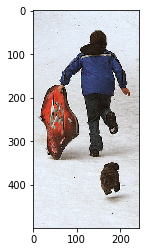

[' startseq two children are playing in the snow endseq',
 ' startseq two children play in the snow endseq',
 ' startseq little boy in red shirt is standing in the snow endseq',
 ' startseq two children are playing in the water endseq',
 ' startseq two children are playing on the snow endseq']

In [183]:
pic = list(encoding_test.keys())[14]
image = encoding_test[pic].reshape((1,2048))
# x=plt.imread(os.getcwd() + '\\data\\Flicker8k_Dataset\\'+pic)
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
run_beam_search(image, model, wordtoix, ixtoword, 3, 32, 1, 5)

# Evaluation

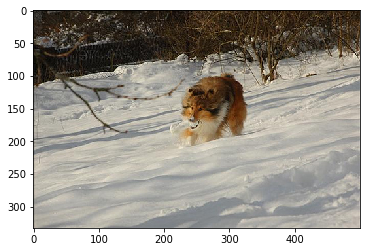

Greedy: dog runs through the snow


In [90]:
z=0
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

In [0]:
filepath = 'model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
# fit model
model.fit([X1train, X2train], ytrain, epochs=20, verbose=2, callbacks=[checkpoint], validation_data=([X1test, X2test], ytest))

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
score, acc = model.evaluate(x_test, y_test, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

# Video Images Captioning

In [0]:
import csv

def write_csvtotext(filename):
  
  output=open(folderName+'/'+'flickr8k_video.token.txt','w')

  with open(filename,"rt", encoding='utf-8') as f:
      f.readline()
      lines = [line.replace('|', '').strip() + '\n' for line in f.readlines()]
      for l in lines:
          output.write(l)
  output.close()

In [0]:
folderName='/content/drive/My Drive/App/storage/TomAndJerry'
imageDir=folderName+'/Images'
filename = folderName+'/'+'test-video.csv'
# write description
write_csvtotext(filename)

In [0]:
#max_length = 21
print('Description Length: %d' % max_length)
# load the model
filename = folderName+'/model_30.h5'
print("filename:",filename)
model = load_model(filename)
# load and prepare the photograph
folderName='/content/drive/My Drive/App/storage/TomAndJerry'
imageDir=folderName+'/Images'
imageFileName = imageDir+'/'+'image0.jpg'
print("imageFileName:", imageFileName)
photo = extract_features(imageFileName)

caption = generate_desc(model, tokenizer, photo, max_length) 
print(caption)